# CAB420, Classificaton Summary with Image Data
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This example revists our classification methods:
* K-Nearest Neighbours Classification
* Support Vector Machines
* Random Forests
* Deep Neural Networks

In this summary example, we're going to use image data and throw that through all four of our methods. While feeding in raw images generally works really well for DCNNs, it's rarely a great choice for other methods. As such, we'll use a feature extraction process with these methods. One thing we won't do in this example is tune the classifiers or optimise them. Putting grid searches everywhere in this example is not going to be computationally efficient, so we'll avoid that, but please look at the second classification summary if you'd like see some grid searches cranking over. One thing we will do here however is have a look at run-times. We normally think of DCNNs as being the big slow behemoth of the machine learning world, so let's see if that holds up.

Hopefully, everything in this example except for the feature will be familar, but if it isn't:
* Ask questions, either in class or online
* Go back and look at the original content in earlier weeks

If you want to dig further into the feature extraction, feel free to ask questions, or check out the bonus example from the classification content which looks at HOG in more detail.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import datetime
import numpy

import keras
from keras import layers

from skimage.feature import hog
from skimage import data, exposure

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import time

## The Data

We're going to use CIFAR-10. We're also going to create three versions of our data.

### Leaving our Data as Images

First up, we have the data as images (i.e. leaving it alone), which we'll use as an input to our Deep Convolutional Neural Network. DCNNs, by virtue of the *convolution* filters that are learnt, can learn over images. These convolution filters will learn to respond to interesting things in the images. This is really critical, as it means that:
* Our DCNNs can learn spatial patterns. This means shapes, textures, and other important visual cues. DCNNs can learn to identify these, and learn how the presence of certains shapes, textures, or such, relates to the things being identified.
* We have some spatial invariance built into our model. If we have the same texture at two different locations, and a convolutional filter tuned to respond that texture, it will respond the same way to both instances. This is important as it means that we can recognise things regardless of where in the image they appear. 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
x_train = x_train / 255.0
x_test = x_test / 255.0

### Vectorising our Data

Next up, we'll vectorise our data. By this, I mean that for each sample rather than having an image, we'll simply have a vector. We can think of this as taking each column of the image, and stacking them. In our case, we'll go from a $32 \times 32 \times 3$ image to a $1 \times 3072$ vector.

This is the format that our non-deep learning methods (CKNN, RF and SVM) want. These models don't consider the spatial relationships between pixels, or even consider the three red, green and blue values as a group. Each channel for each pixel is simply seen as it's own dimension.

In [3]:
x_train_vectorised = x_train.reshape(-1, 3072).astype('float32')
x_test_vectorised = x_test.reshape(-1, 3072).astype('float32')

### Feature Extraction via Histogram of Orientated Gradients (HOG)

Finally, we'll throw something new in the mix. In general, non-deep learning methods are really bad at learning over raw pixels. There's a few reasons for this:
* Often, these "raw pixel" representations are huge. Huge feature vectors are harder to learn from and are more prone to overfitting.
* Small shifts mean big changes. If we take an image of a car, and shift it to the left by 1 pixel, it's still a car. But in the vectorised representation we've used above, potentially every single feature (i.e. the value of each pixel) has changed. This is less than ideal.
* The same thing happens for a lighting change. CIFAR-10 is captured in natural light, and a small change in the lighting will mean every single feature value changes. Again, not great.

As a result, rather than use raw pixels it is generally much better to use a *feature extractor* to obtain an alternate representation. In this case, I'm using the Histogram of Oriented Gradients (though the specific method is really not important here). What this will do is get an alternate representation based on the gradients in local image patches and will mean that:
* I have a more compact feature
* I have some invariance to changes in lighting, and small changes in location

There are a lot of other feature extractors that I could use (see [here](https://scikit-image.org/docs/stable/api/skimage.feature.html) for what's in skimage for example) and while each method does something a bit different, they all are based around this idea of trying to find a better representation of the data to learn from. The idea of feature representation is not restricted to images either, and pops up in places like audio or text as well. We could also see the variable selection process that we've used in linear regression (i.e. removing terms with poor p-values, highly correlated predictors, etc) as a form of feature extraction.

My point here is simply that this is par for the course.

#### Ok, so why isn't this a problem for DCNNs?

Excellent question. The answer is the *C* bit in DCNN. 

Thinking about a convolution layer, this will take a collection of filters, slide these across the image, and produce some response maps that describe how strongly each filter responds to the image at each location. The results of this are then passed down to the next convolution layer, and it all repeats again (and again).

Back to HOG now. HOG will take a local patch of the image, look for gradients (edges) in different orientations, and build a histogram of what gradients are present in each patch. We could think of each of our orientations as being a single convolution filter that's looking for edges in a specific direction (and you've hopefully seen that this is exactly what some of our early convolution filters look like). So we can think of HOG as being a set of pre-defined convolution filters, the results of which are then summed in someway across small image patches; and we can view what a DCNN does as both learning what the features are, and how to classify them, directly from the data.

The idea of learning the optimal set of features straight from the data is incredibly powerful, and is a large part of what has led to the huge gains DCNNs and deep learning in general has made. This does also lead to the need for lots of data, as per the [no free lunch theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem), but the important message is that deep learning doesn't mean that we no longer need features, it just means that these are learnt from the data.

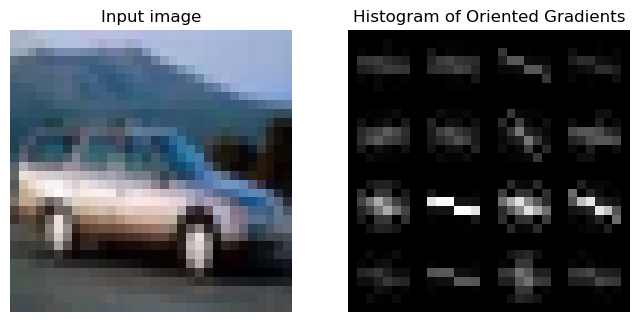

(128,)


In [4]:
# call HOG. Note that visualise is True. This means that we'll get our transformed feautre back, fd,
# and a visualised image
fd, hog_image = hog(x_train[4,:,:,:], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=2)

# display image and HOG representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(x_train[4,:,:], cmap=plt.cm.gray)
ax1.set_title('Input image')
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

print(fd.shape)

The above shows a visualisation of what we get out of HOG (again this isn't super important, what's is important is just this idea of *features*). We have $32 \times 32 \times 3$ images, have *cells* of size $8 \times 8$, and $8$ orientations. For each non-overlapping $8 \times 8$ region, we generate an $8$ bin histogram of gradient orientations, showing us the directions of edges in that image.

So the image is now characterised by $\frac{32}{8} \times \frac{32}{8} \times 8 = 128$ features, rather than the $3072$ raw pixels.

In [5]:
def transform_datset_to_hog(data, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1)):
    hog_data = []
    for im in range(data.shape[0]):
        hog_data.append(hog(data[im,:,:,:], orientations=orientations, pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block, visualize=False, channel_axis=2, feature_vector=True))
    return numpy.array(hog_data)

hog_start = time.process_time()
x_train_hog = transform_datset_to_hog(x_train)
hog_mid = time.process_time()
x_test_hog = transform_datset_to_hog(x_test)
hog_stop = time.process_time()
print('%f second to process %d training images; %f seconds to process %d testing images' % \
      (hog_mid - hog_start, len(x_train), hog_stop - hog_mid, len(x_test)))

17.184304 second to process 50000 training images; 3.407715 seconds to process 10000 testing images


As we can see above, the time taken to transform our data to HOG features is not trivial; though it's not too astronomical.

## Non-Deep Learning Classification

You've hopefully seen by now that using sklearn, the classifiers all have a very similar looking API (if not, go and look at the previous CAB420 examples, or look [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)).

With that in mind, I'm going to use a couple of simple functions to streamline the process for us.

In [6]:
def eval_model_nondl(model, X_train, Y_train, X_test, Y_test, verbose = False):

    train_pred_start = time.process_time()
    pred = model.predict(X_train)
    train_pred_end = time.process_time()

    if (verbose):
        fig = plt.figure(figsize=[25, 8])
        ax = fig.add_subplot(1, 2, 1)
        conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)

        conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));

    test_pred_start = time.process_time()
    pred = model.predict(X_test)
    test_pred_end = time.process_time()
    test_acc = sum(pred == Y_test)/len(Y_test)

    if (verbose):
        ax = fig.add_subplot(1, 2, 2)
        conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
        conf.ax_.set_title('Testing Set Performance: ' + str(test_acc));

        print(classification_report(y_test, pred))
    
    return (train_pred_end - train_pred_start), (test_pred_end - test_pred_start), test_acc

def train_and_eval_nondl(model,x_train, y_train, x_test, y_test, verbose = False):

    train_start = time.process_time()
    model.fit(x_train, y_train)
    train_end = time.process_time()
    train_time = train_end - train_start

    pred_train_time, pred_test_time, acc = eval_model_nondl(model, x_train, y_train, x_test, y_test, verbose)
    
    return train_time, pred_train_time, pred_test_time, acc

### A Parameter to Play With

In the bit below, I'm not going to use all the samples in the non-deep learning models. This isn't about me biasing the rest of the example towards the DCNN, rather it's a practical consideration. Very large datasets, with 10,000's of examples, are a fairly recent thing. It's the existence of these datasets together with GPUs that have fuelled deep learning. SVMs and CKNNs were never really intended to work with datasets of this size, and they can get a little bit slow as dataset size increases. As such, the below controls how many samples are used with the CKNN, SVM and Random Forest. Feel to change this, but do so with caution.

In [7]:
samples_to_use = 1000

### K-Nearest Neighbours Classification

We'll start with [K-Nearest Neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). This method will classify a given test sample by finding the $K$ nearest points to it in the training set, and then looking at the class of these points. K-Nearest Neighbours has three main levers that we've looked at:
* The number of neighbours, `n_neighbours`. Making this bigger means that we're looking at a larger set of neighbours when making a decision. Larger values will better cope with noise, but will be a hinderence when we have small classes, or highly fragmented feature spaces.
* The weighting scheme, specified by `weights`. When set of `uniform` it means that all neighbours are weighted equally. We could also use `distance` which would use an inverse distance weighting, such that neighbours closer to the point in question get a higher weight.
* The distance metric, specified by `metric`, which determines how we calculate the distance between two points. This can have a big impact on the shape of the boundary that we learn.

We'll train a model with some default values for the above for both the raw pixel data and the HOG data.

              precision    recall  f1-score   support

           0       0.38      0.46      0.42      1000
           1       0.42      0.01      0.02      1000
           2       0.14      0.32      0.20      1000
           3       0.16      0.01      0.01      1000
           4       0.18      0.53      0.27      1000
           5       0.71      0.04      0.07      1000
           6       0.19      0.27      0.22      1000
           7       0.48      0.03      0.06      1000
           8       0.31      0.59      0.41      1000
           9       0.49      0.05      0.09      1000

    accuracy                           0.23     10000
   macro avg       0.35      0.23      0.18     10000
weighted avg       0.35      0.23      0.18     10000

Training Time: 0.001227; Evaluation Time (Test Data): 1.612871


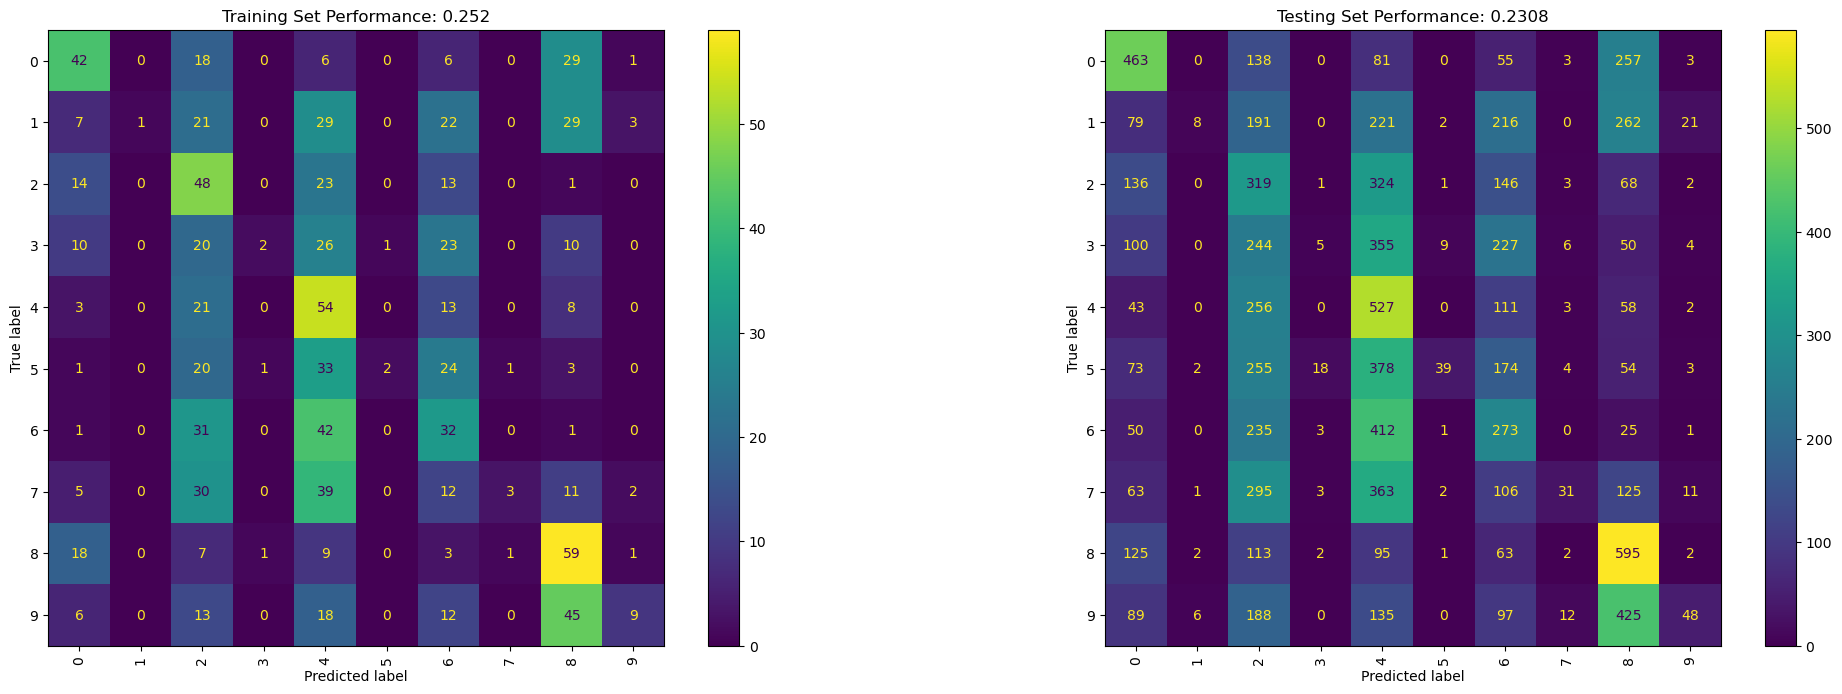

In [8]:
cknn = KNeighborsClassifier(n_neighbors=50, weights='uniform', metric='euclidean')
cknn_metrics = train_and_eval_nondl(cknn, x_train_vectorised[0:samples_to_use,:], y_train[0:samples_to_use], \
                                    x_test_vectorised, y_test, verbose=True)
print('Training Time: %f; Evaluation Time (Test Data): %f' % (cknn_metrics[0], cknn_metrics[2]))

              precision    recall  f1-score   support

           0       0.66      0.10      0.17      1000
           1       0.39      0.22      0.28      1000
           2       0.32      0.01      0.02      1000
           3       0.35      0.02      0.04      1000
           4       0.15      0.23      0.18      1000
           5       0.25      0.02      0.03      1000
           6       0.14      0.96      0.24      1000
           7       0.52      0.04      0.07      1000
           8       0.45      0.17      0.25      1000
           9       0.31      0.04      0.07      1000

    accuracy                           0.18     10000
   macro avg       0.35      0.18      0.13     10000
weighted avg       0.35      0.18      0.13     10000

Training Time: 0.000889; Evaluation Time (Test Data): 0.337560


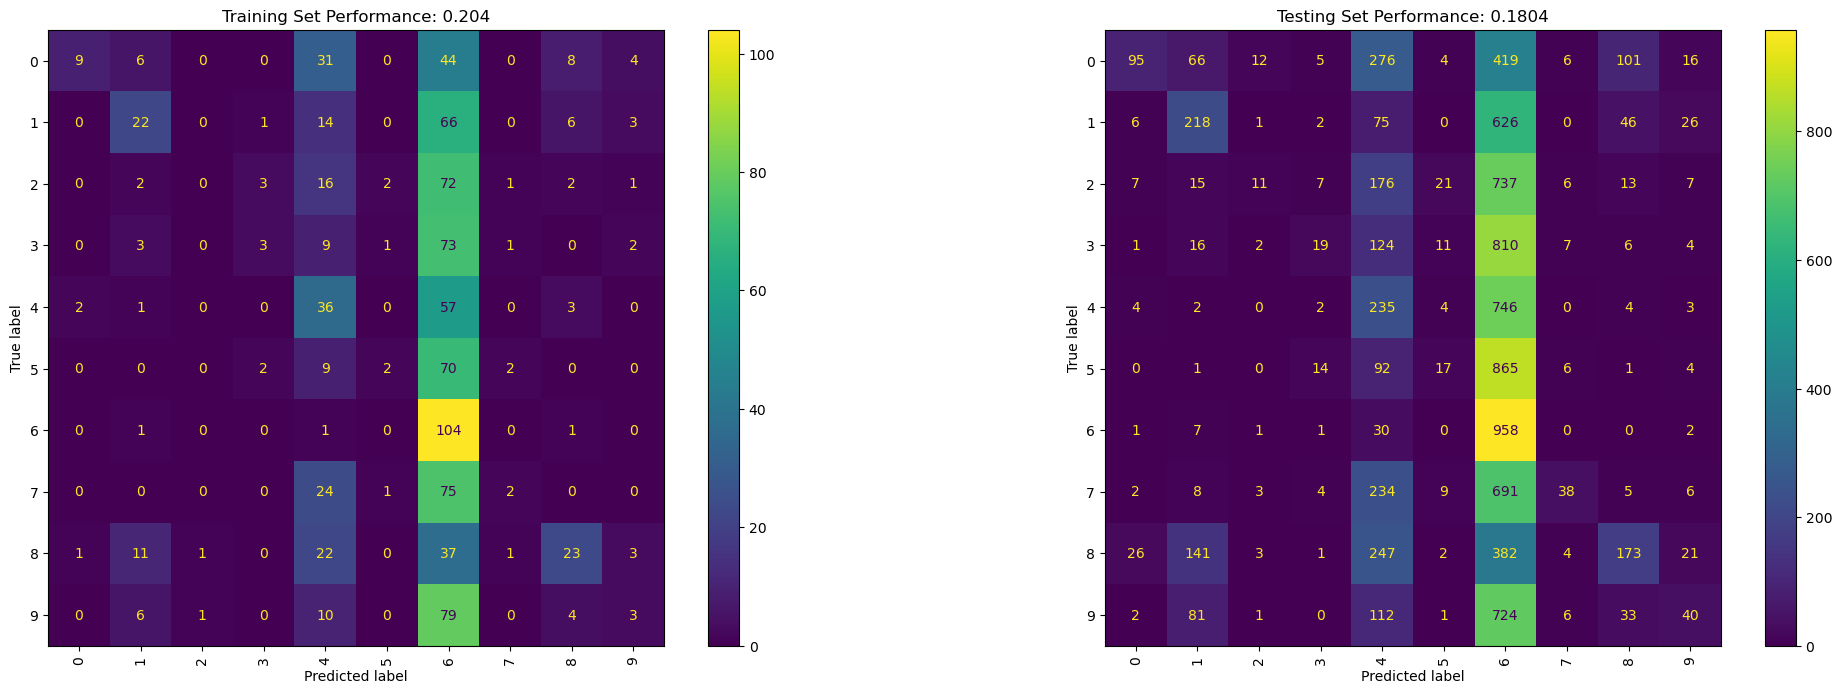

In [9]:
cknn_hog = KNeighborsClassifier(n_neighbors=50, weights='uniform', metric='euclidean')
cknn_metrics = train_and_eval_nondl(cknn_hog, x_train_hog[0:samples_to_use, :], \
                                    y_train[0:samples_to_use].reshape(-1), x_test_hog, y_test.reshape(-1), verbose=True)
print('Training Time: %f; Evaluation Time (Test Data): %f' % (cknn_metrics[0], cknn_metrics[2]))

#### Observations

* Training time for both is negligible. There is nothing really learnt here, it simply organsises the data to make it faster to index layer
* The HOG based method is much faster. The more compact features mean that each distance computation is much quicker. We've gone from 3072 to 128 features, a 24 times reduction. We don't quite see the same reduction in run time for the evaluation (other operations mean we can't get that sized saving), but it's much, much faster.

### Support Vector Machines

SVMs are natively a binary classifier. The find a boundary between two classes (a hyper-plane), and then when a new point they check what side of the hyper-plane the point falls on, to determine what class it is. In the binary form, we have the following things to play with:
* C
* Kernel
* Kernel Parameters

To extend these to a multi-class setting, we use an *ensemble* of binary classifiers. Essentially, we transform our problem from a single multi-class classification task into a set of binary classification tasks. The simplest way of doing this is with a 1 vs All approach. If we have 10 classes, this means that we train classifiers to:
* separate class 1 from classes 2, 3, 4, 5, 6, 7, 8, 9 and 10
* separate class 2 from classes 1, 3, 4, 5, 6, 7, 8, 9 and 10
* ...
* separate class 10 from classes 1, 2, 3, 4, 5, 6, 7, 8 and 9
So if we have $N$ classes, we have $N$ classifiers.

The other option we have is a 1 vs 1 scheme. In this case we will train classifiers to:
* separate class 1 from class 2
* separate class 1 from class 3
* separate class 1 from class 4
* ...
* separate class 1 from class 10
* separate class 2 from class 3
* separate class 2 from class 4
* ...
* separate class 2 from class 10
* ...

And so on. All up, we'd have $9 + 8 + 7 + .. + 2 + 1 = \sum_{i=1}^{N-1}i = 45$ different SVMs (where $N$ is the number of classes). 

Once we've got our ensemble, when we wish to evaluate a test sample we pass that through all models in the ensemble (10 or 45 in this case), and aggregrate the results. 

Here, we'll use an SVM with the default settings ($C=1.0$, RBF kernel, see [the documentation for details](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)) and consider the impact of the different encodings and the two different sets of features. As per the CKNN, note that this means that our performance will probably not be optimal, and  you're strongly encouraged to play with the SVM hypep-parameters, particularly  if you haven't already done so elsewhere. 

              precision    recall  f1-score   support

           0       0.43      0.47      0.45      1000
           1       0.39      0.55      0.46      1000
           2       0.28      0.25      0.26      1000
           3       0.22      0.17      0.19      1000
           4       0.35      0.30      0.32      1000
           5       0.29      0.21      0.25      1000
           6       0.38      0.38      0.38      1000
           7       0.40      0.42      0.41      1000
           8       0.44      0.52      0.48      1000
           9       0.41      0.41      0.41      1000

    accuracy                           0.37     10000
   macro avg       0.36      0.37      0.36     10000
weighted avg       0.36      0.37      0.36     10000

Training Time: 3.460181; Evaluation Time (Test Data): 48.021972


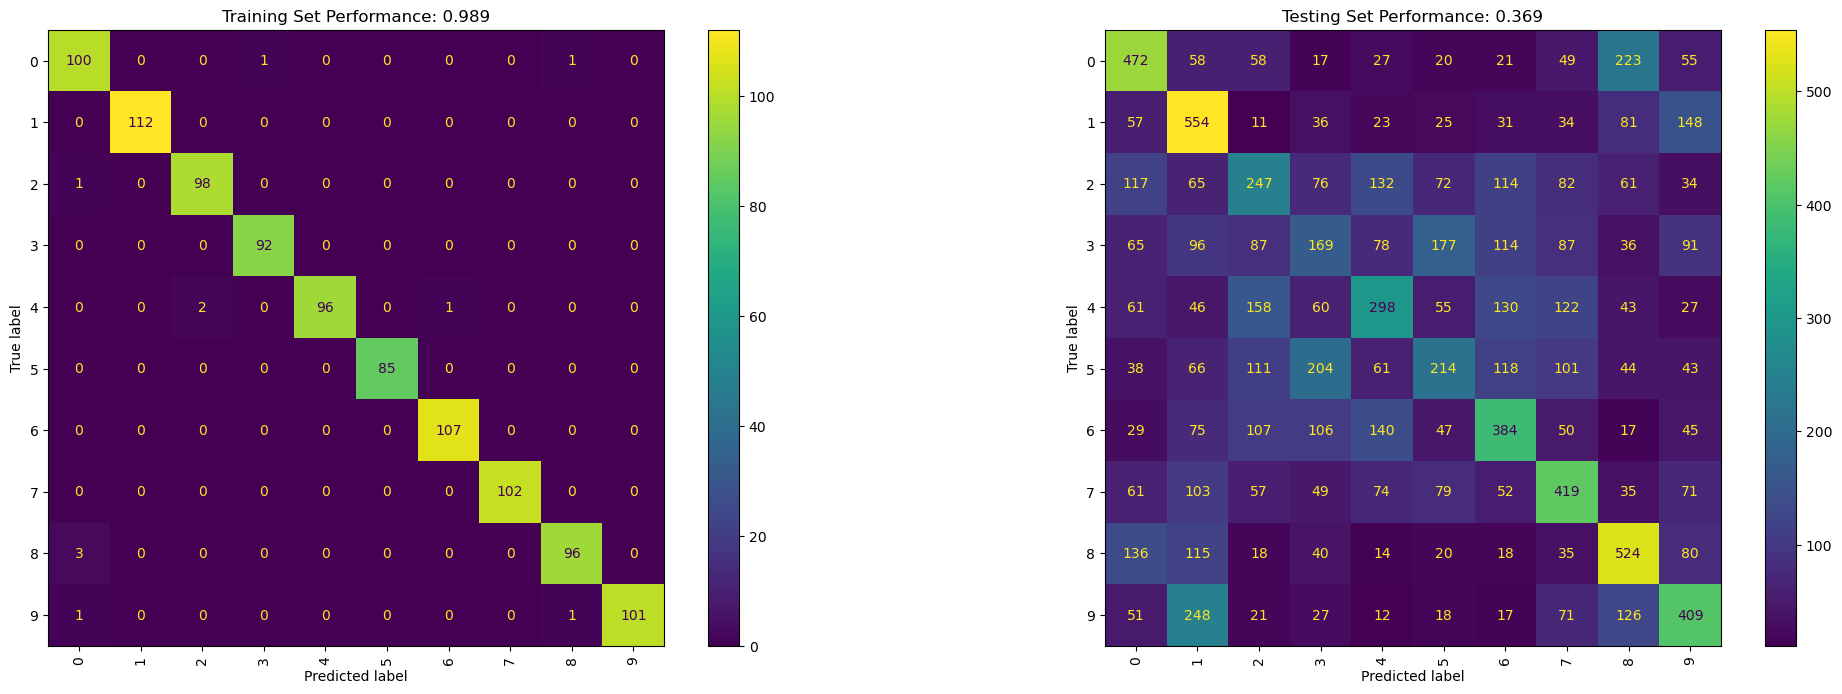

In [10]:
onevsall_svm = OneVsRestClassifier(SVC())
svm_metrics = train_and_eval_nondl(onevsall_svm, x_train_vectorised[0:samples_to_use, :], \
                                   y_train[0:samples_to_use], x_test_vectorised, y_test, verbose = True)
print('Training Time: %f; Evaluation Time (Test Data): %f' % (svm_metrics[0], svm_metrics[2]))

              precision    recall  f1-score   support

           0       0.46      0.42      0.44      1000
           1       0.40      0.44      0.42      1000
           2       0.26      0.25      0.25      1000
           3       0.25      0.15      0.18      1000
           4       0.33      0.34      0.33      1000
           5       0.34      0.24      0.28      1000
           6       0.32      0.47      0.38      1000
           7       0.39      0.35      0.37      1000
           8       0.44      0.52      0.48      1000
           9       0.39      0.46      0.42      1000

    accuracy                           0.36     10000
   macro avg       0.36      0.36      0.36     10000
weighted avg       0.36      0.36      0.36     10000

Training Time: 0.943987; Evaluation Time (Test Data): 154.453789


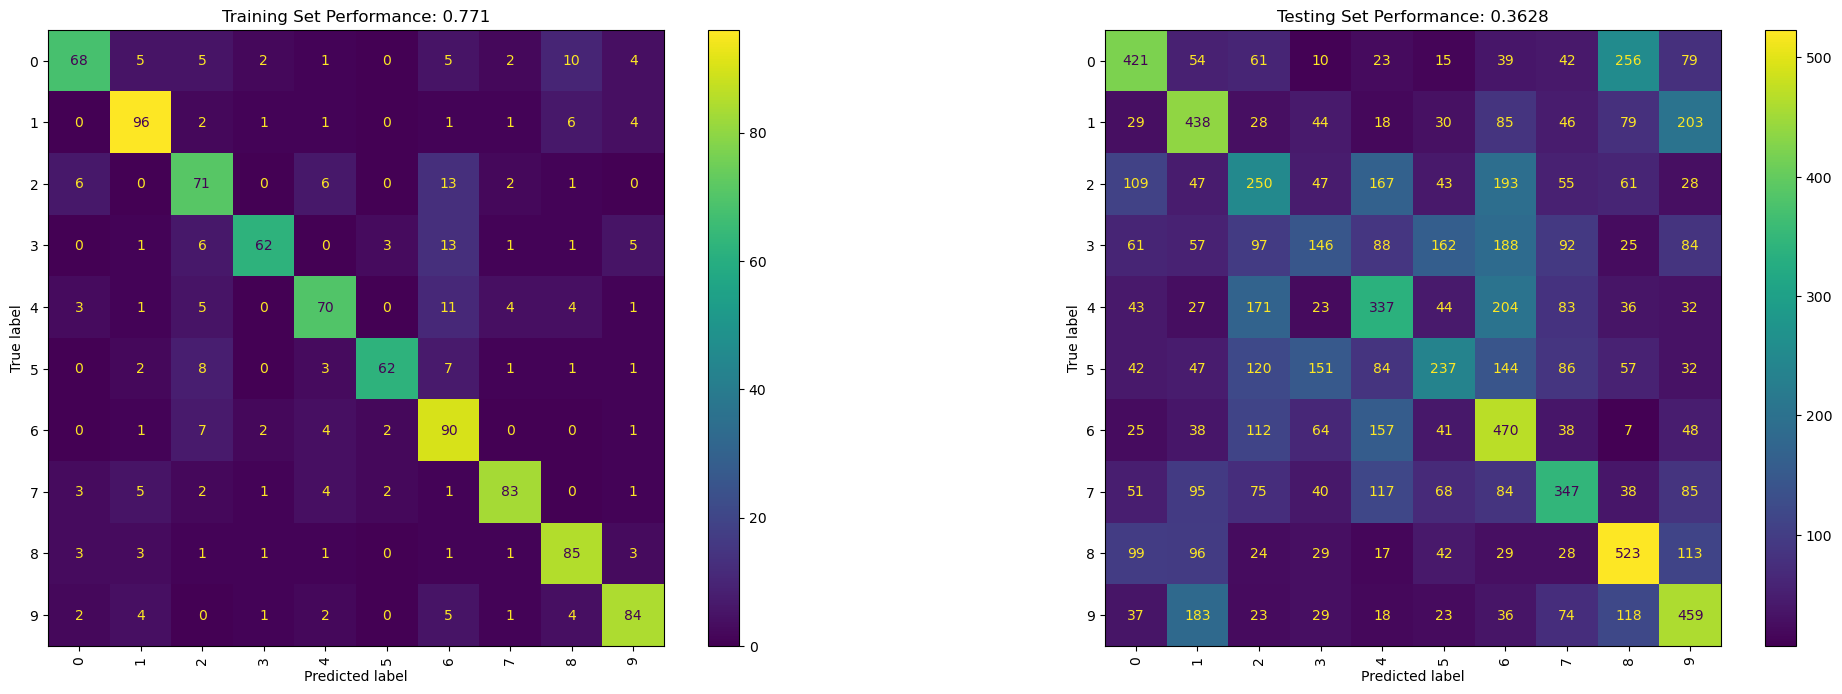

In [11]:
onevsone_svm = OneVsOneClassifier(SVC())
svm_metrics = train_and_eval_nondl(onevsone_svm, x_train_vectorised[0:samples_to_use, :], \
                                   y_train[0:samples_to_use], x_test_vectorised, y_test, verbose = True)    
print('Training Time: %f; Evaluation Time (Test Data): %f' % (svm_metrics[0], svm_metrics[2]))

              precision    recall  f1-score   support

           0       0.40      0.42      0.41      1000
           1       0.42      0.65      0.51      1000
           2       0.33      0.22      0.26      1000
           3       0.29      0.21      0.24      1000
           4       0.33      0.29      0.31      1000
           5       0.29      0.22      0.25      1000
           6       0.40      0.44      0.42      1000
           7       0.41      0.47      0.44      1000
           8       0.41      0.46      0.43      1000
           9       0.41      0.40      0.41      1000

    accuracy                           0.38     10000
   macro avg       0.37      0.38      0.37     10000
weighted avg       0.37      0.38      0.37     10000

Training Time: 0.212244; Evaluation Time (Test Data): 2.845328


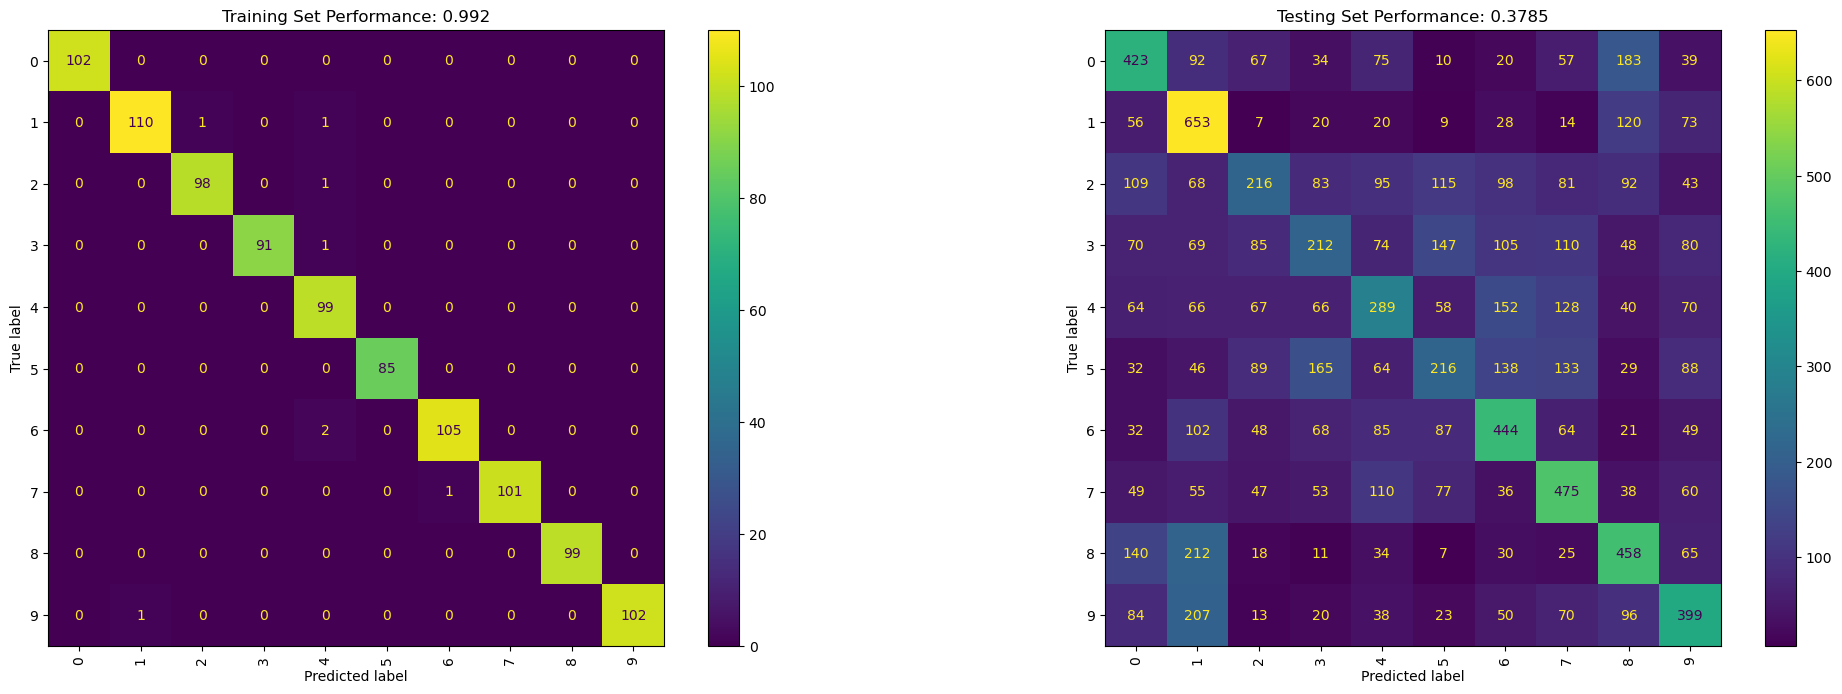

In [12]:
onevsall_svm_hog = OneVsRestClassifier(SVC())
svm_metrics = train_and_eval_nondl(onevsall_svm_hog, x_train_hog[0:samples_to_use, :], \
                                   y_train[0:samples_to_use], x_test_hog, y_test, verbose = True)
print('Training Time: %f; Evaluation Time (Test Data): %f' % (svm_metrics[0], svm_metrics[2]))

              precision    recall  f1-score   support

           0       0.40      0.43      0.42      1000
           1       0.50      0.57      0.54      1000
           2       0.30      0.24      0.27      1000
           3       0.30      0.23      0.26      1000
           4       0.34      0.36      0.35      1000
           5       0.36      0.27      0.31      1000
           6       0.38      0.55      0.45      1000
           7       0.41      0.41      0.41      1000
           8       0.46      0.42      0.44      1000
           9       0.43      0.45      0.44      1000

    accuracy                           0.39     10000
   macro avg       0.39      0.39      0.39     10000
weighted avg       0.39      0.39      0.39     10000

Training Time: 0.090993; Evaluation Time (Test Data): 9.402362


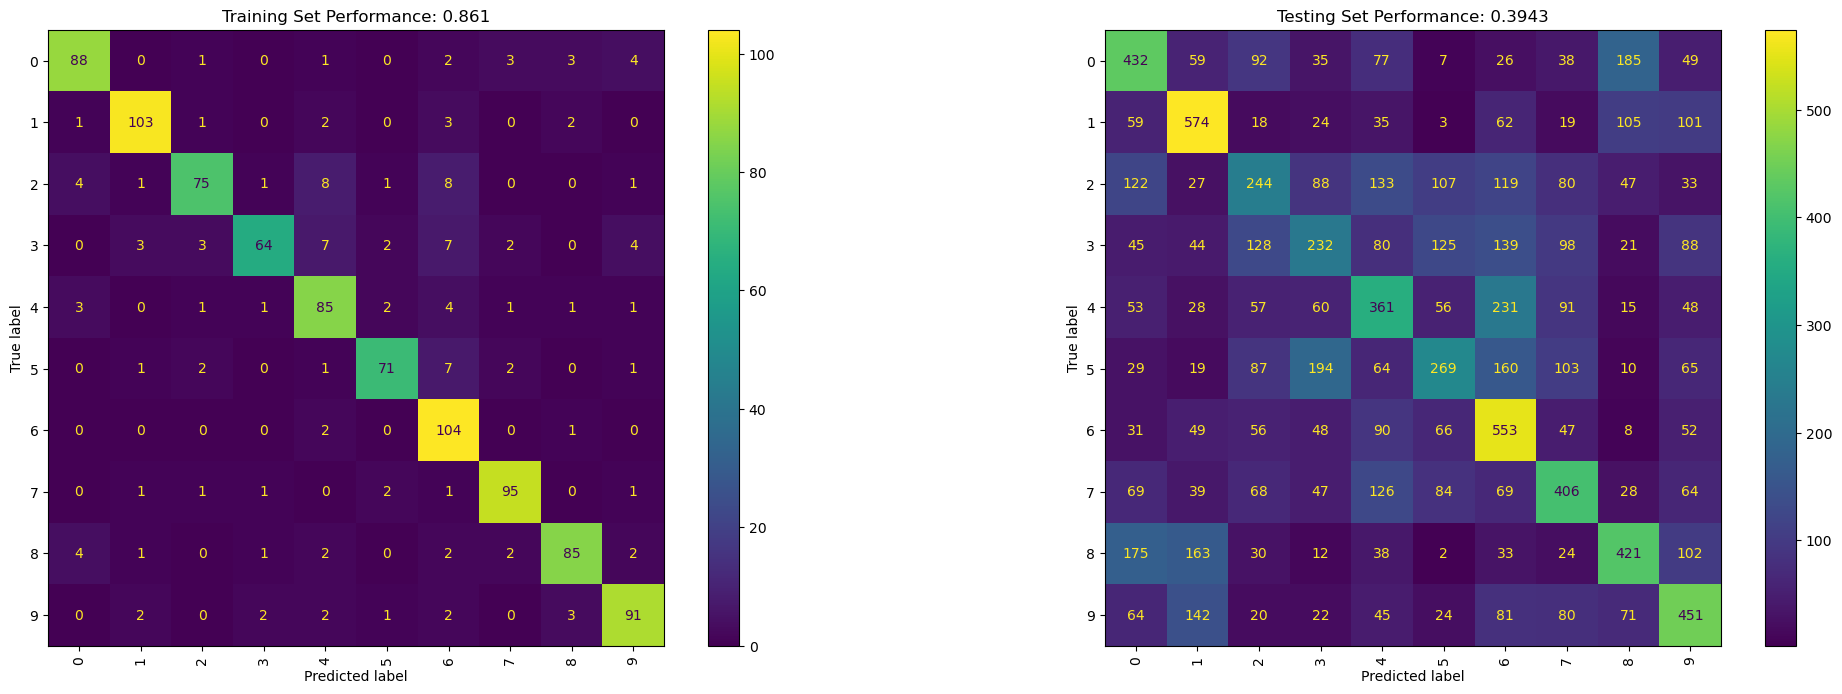

In [13]:
onevsone_svm_hog = OneVsOneClassifier(SVC())
svm_metrics = train_and_eval_nondl(onevsone_svm_hog, x_train_hog[0:samples_to_use, :], \
                                   y_train[0:samples_to_use], x_test_hog, y_test, verbose = True)    
print('Training Time: %f; Evaluation Time (Test Data): %f' % (svm_metrics[0], svm_metrics[2]))

#### Observations

* We see a one vs one model is a lot slower to run than a one vs all. This is to be expected. When we evaluate the one vs all model we pass a point through $10$ SVMs, for the one vs one, it's $45$.
* Again, we see the HOG features leading to a massive increase in speed. This is again down to distances now being much faster to compute.

If you run this with different numbers of training samples, you'll also see times go up a lot as the number of training samples increases.

### Random Forests

Time for the last non-DL method, random forests. Again, we have a couple of main levers here to play with:
* n_estimators
* max_depth

max_depth is the one that will have the largest impact on performance. The deeper we make our trees, the more fine-grained or detailed their decision making process can become. We need max_depth to be big enough to allow the trees to make enough decisions to split the data into the classes, but if we have too much depth we'll end up with our trees overfitting. In general, we also will want more depth with more input dimensions, simply as there are more dimensions that we need to use to make splits to separate things. 

n_estimators is one that, to an extent, we really just want to make as big as possible. More trees means that we'll better smooth out the noise in the invididual noisy predictors (each tree is a noisy predictor), and get better performance overall. However, our complexity increases with each tree that we add - so for practical reasons we don't want to get set this to some huge number. We will reach a point however where we have enough trees to cover the overall space well and smooth out the noise we're seeing. This magic number will depend on the problem itself (how many classes, how many dimensions, how complex is the boundary between classes), but it's probably going be a number in the 100's, or maybe more.

We'll start by just picking some numbers and seeing what happens.

              precision    recall  f1-score   support

           0       0.42      0.46      0.44      1000
           1       0.39      0.45      0.42      1000
           2       0.23      0.23      0.23      1000
           3       0.21      0.09      0.13      1000
           4       0.32      0.34      0.33      1000
           5       0.32      0.25      0.28      1000
           6       0.32      0.48      0.39      1000
           7       0.41      0.32      0.36      1000
           8       0.44      0.49      0.46      1000
           9       0.41      0.44      0.42      1000

    accuracy                           0.36     10000
   macro avg       0.35      0.36      0.35     10000
weighted avg       0.35      0.36      0.35     10000

Training Time: 6.697821; Evaluation Time (Test Data): 0.543893


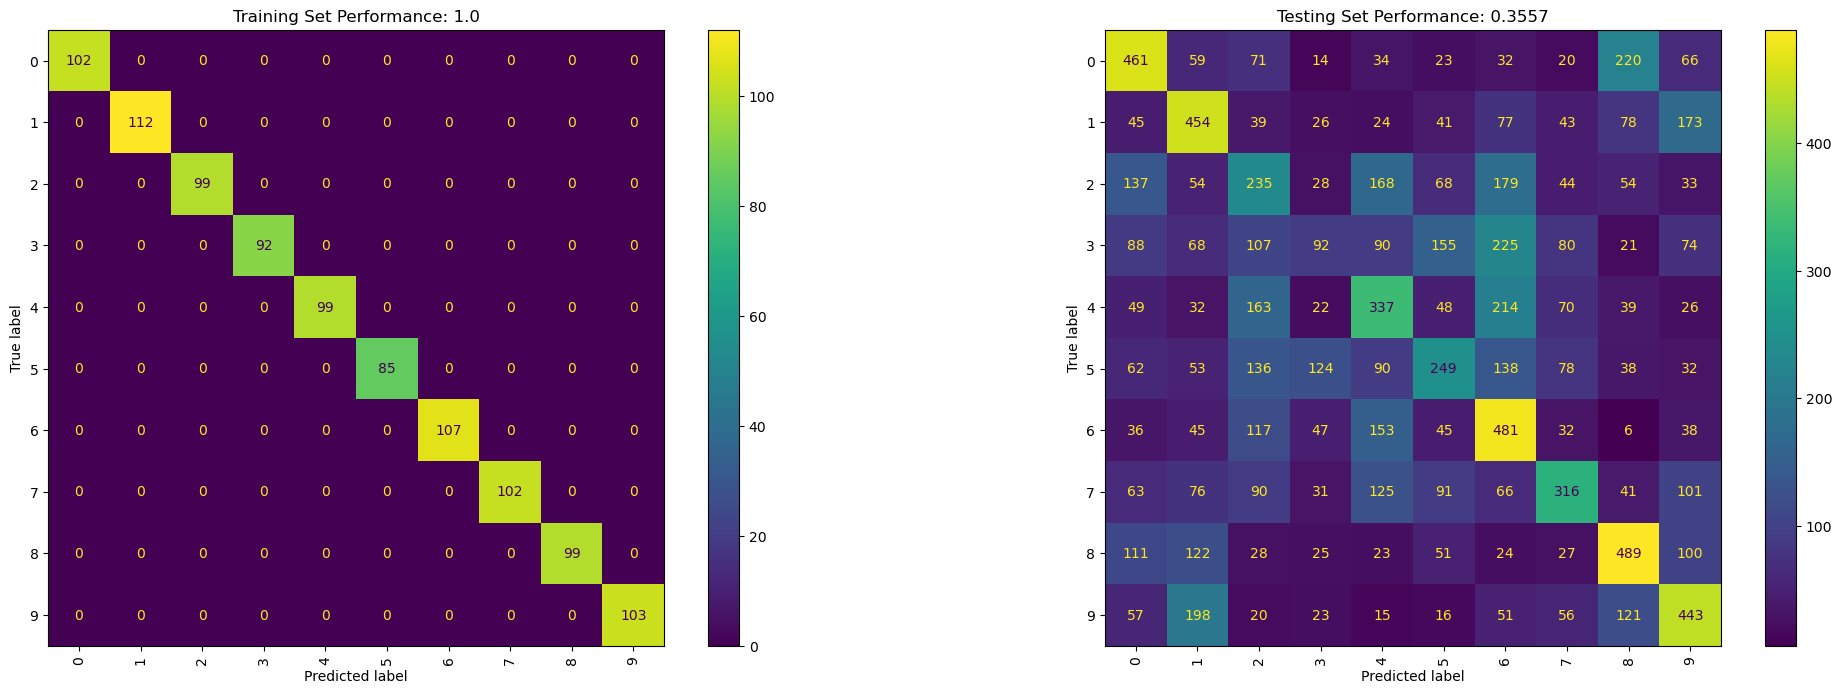

In [14]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0)
rf_metrics = train_and_eval_nondl(rf, x_train_vectorised[0:samples_to_use, :], \
                                  y_train[0:samples_to_use], x_test_vectorised, y_test, verbose = True)    
print('Training Time: %f; Evaluation Time (Test Data): %f' % (rf_metrics[0], rf_metrics[2]))

              precision    recall  f1-score   support

           0       0.46      0.34      0.39      1000
           1       0.41      0.61      0.49      1000
           2       0.29      0.19      0.23      1000
           3       0.28      0.19      0.23      1000
           4       0.32      0.28      0.30      1000
           5       0.30      0.23      0.26      1000
           6       0.33      0.60      0.43      1000
           7       0.38      0.37      0.37      1000
           8       0.46      0.47      0.46      1000
           9       0.38      0.37      0.38      1000

    accuracy                           0.36     10000
   macro avg       0.36      0.36      0.35     10000
weighted avg       0.36      0.36      0.35     10000

Training Time: 1.728795; Evaluation Time (Test Data): 0.215150


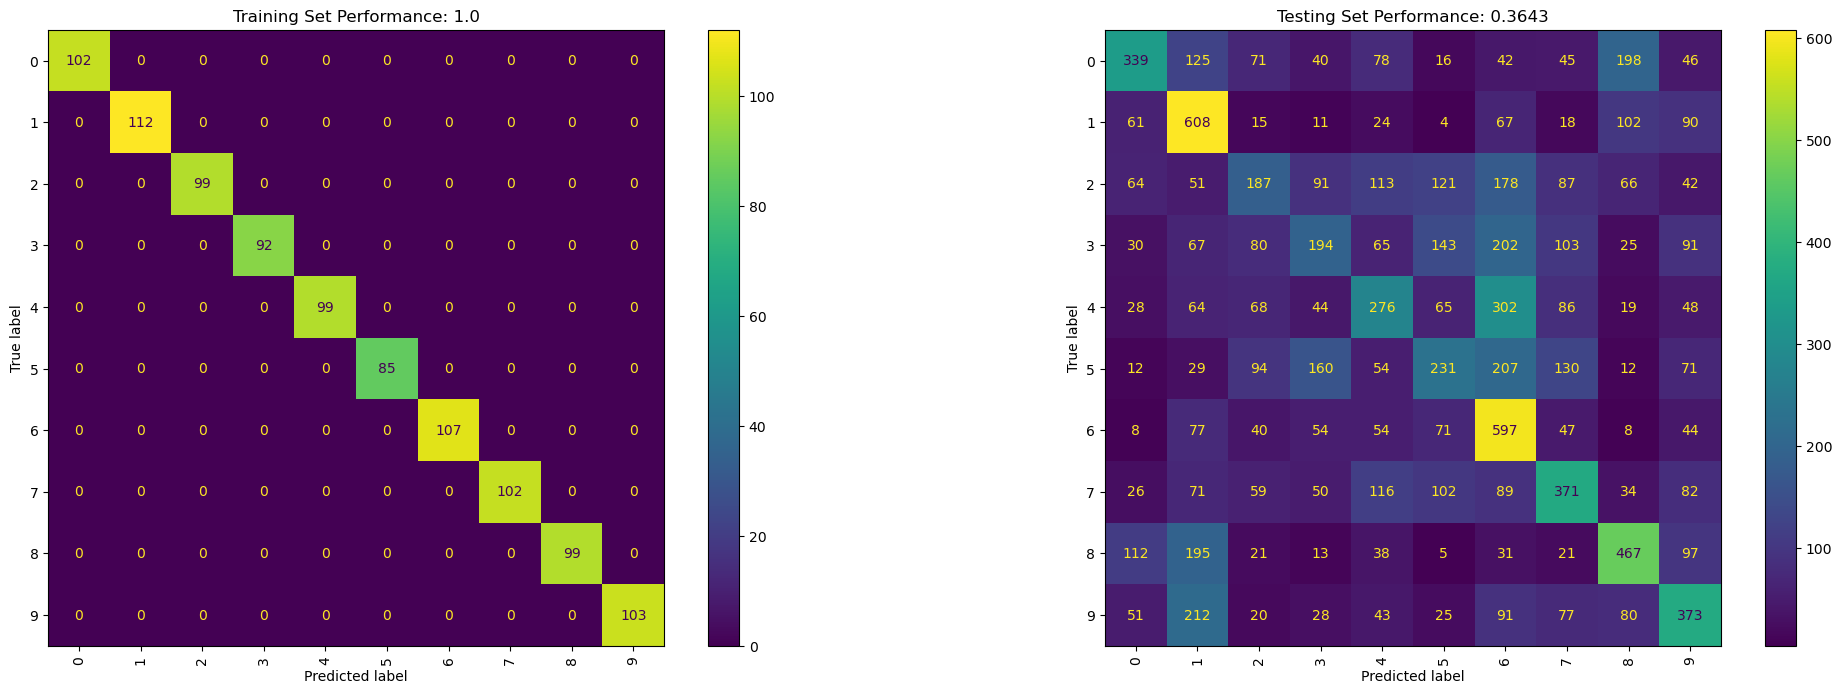

In [15]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0)
rf_metrics = train_and_eval_nondl(rf, x_train_hog[0:samples_to_use, :], \
                                  y_train[0:samples_to_use], x_test_hog, y_test, verbose = True)    
print('Training Time: %f; Evaluation Time (Test Data): %f' % (rf_metrics[0], rf_metrics[2]))

#### Observations

* Our RF is much faster than both the CKNN and SVM
* Evaluation time is very similar for raw pixels and HOG
* Training time is faster for the HOG data, but not that much faster (or at least not to the same level in terms of dimensions saved).

### Deep Convolutional Neural Networks

Let's throw a DCNN at this now. I'm going to keep the model simple. There's a of other things that we could do with this model, including:
* More convolution layers. We could use stacked convolution operations, in the style of VGG net
* Add batch normalisation, or dropout
* Switch to a resnet architecture
* Use a pre-trained network
* Use data augmentation

All of these (and more!) would be good things to do to improve our model. However, we'll keep it simple (though you are, as always, encouraged to play and see what you can do).

One thing to discuss briefly is our training setup. Here, we're going to use all the data. Is this cheating? Yes, kind-of. But from the run-times above, do you really want to run a 1v1 SVM with all 50,000 training samples? For our training, we're going to use a batch size of 64. This means we'll get $\frac{50,000}{64} = 781$ updates per batch. Across 20 epochs, it gives us $781 \times 20 = 15,625$ gradient descent updates. It's reasonable to expect this to be sufficient to train our network. 

Remember, when setting up your network for training you should always consider the size of the dataset and the size of a batch and set the number of epochs appropriately. If you're unsure, set it for longer than you think reasonable and use an early stopping callback, and/or model checkpoints.

In [16]:
# function to build the network
def build_network():
    # colour image input, 32x32 pixels
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    # very simple network, conv2D followed by max-pooling, start with 8 filters
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # 16 filters
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # 32 filters
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
    # flatten it out, and into a dense layer
    x = layers.Flatten()(x)
    # one dense layer to aggregrate convolutional features
    x = layers.Dense(64, activation='relu')(x)
    # and now out classification layer
    outputs = layers.Dense(10, activation='softmax')(x)

    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='cifar10_cnn_model')
    model_cnn.summary()

    return model_cnn
    
# evaluate function
def eval_model_dl(model, x_train, y_train, x_test, y_test, verbose = False):

    # predict on the training set
    train_pred_start = time.process_time()
    pred = model.predict(x_train, verbose=False)
    train_pred_end = time.process_time()

    # plot confusion matrices
    if (verbose):
        fig = plt.figure(figsize=[25, 8])
        ax = fig.add_subplot(1, 2, 1)

        indexes = keras.ops.argmax(pred, axis=1)

        cm = confusion_matrix(y_train, indexes)
        c = ConfusionMatrixDisplay(cm, display_labels=range(10))
        c.plot(ax = ax)
        ax.set_title('Training Set Performance: ' + str(sum(indexes.numpy() == y_train)/len(y_train)));

    # predict on the test set
    test_pred_start = time.process_time()
    pred = model.predict(x_test, verbose=False)
    test_pred_end = time.process_time()
    indexes = keras.ops.argmax(pred, axis=1)
    test_acc = sum(indexes.numpy() == y_test)/len(y_test)

    # plot confusion matricies
    if (verbose):
        ax = fig.add_subplot(1, 2, 2)

        cm = confusion_matrix(y_test, indexes)
        c = ConfusionMatrixDisplay(cm, display_labels=range(10))
        c.plot(ax = ax)
        ax.set_title('Testing Set Performance: ' + str(test_acc));

        print(classification_report(y_test, indexes))

    # return prediction times for training and testing sets, and the testing accuracy
    return (train_pred_end - train_pred_start), (test_pred_end - test_pred_start), test_acc
    
def train_and_eval_cnn(x_train, y_train, x_test, y_test, verbose = False):
    model_cnn = build_network()
    model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
    dcnn_train_start = time.process_time()
    history = model_cnn.fit(x_train, y_train,
                            batch_size=64,
                            epochs=20,
                            validation_split=0.2, verbose=False)
    dcnn_train_end = time.process_time()
    dcnn_train_time = dcnn_train_end - dcnn_train_start

    dcnn_metrics = eval_model_dl(model_cnn, x_train, y_train, x_test, y_test, verbose)

    return model_cnn, dcnn_train_time, dcnn_metrics    

Model: "cifar10_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 8)         │        224 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 32)          │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 64)                │     32,832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │        650 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 39,514 (154.35 KB)

 Trainable params: 39,514 (154.35 KB)

 Non-trainable params: 0 (0.00 B)

              precision    recall  f1-score   support

           0       0.78      0.57      0.66      1000
           1       0.78      0.74      0.76      1000
           2       0.59      0.45      0.51      1000
           3       0.42      0.55      0.48      1000
           4       0.60      0.59      0.60      1000
           5       0.54      0.52      0.53      1000
           6       0.68      0.77      0.72      1000
           7       0.66      0.73      0.69      1000
           8       0.71      0.79      0.75      1000
           9       0.76      0.69      0.72      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000

Training Time: 34.967847; Evaluation Time (Test Data): 0.526480


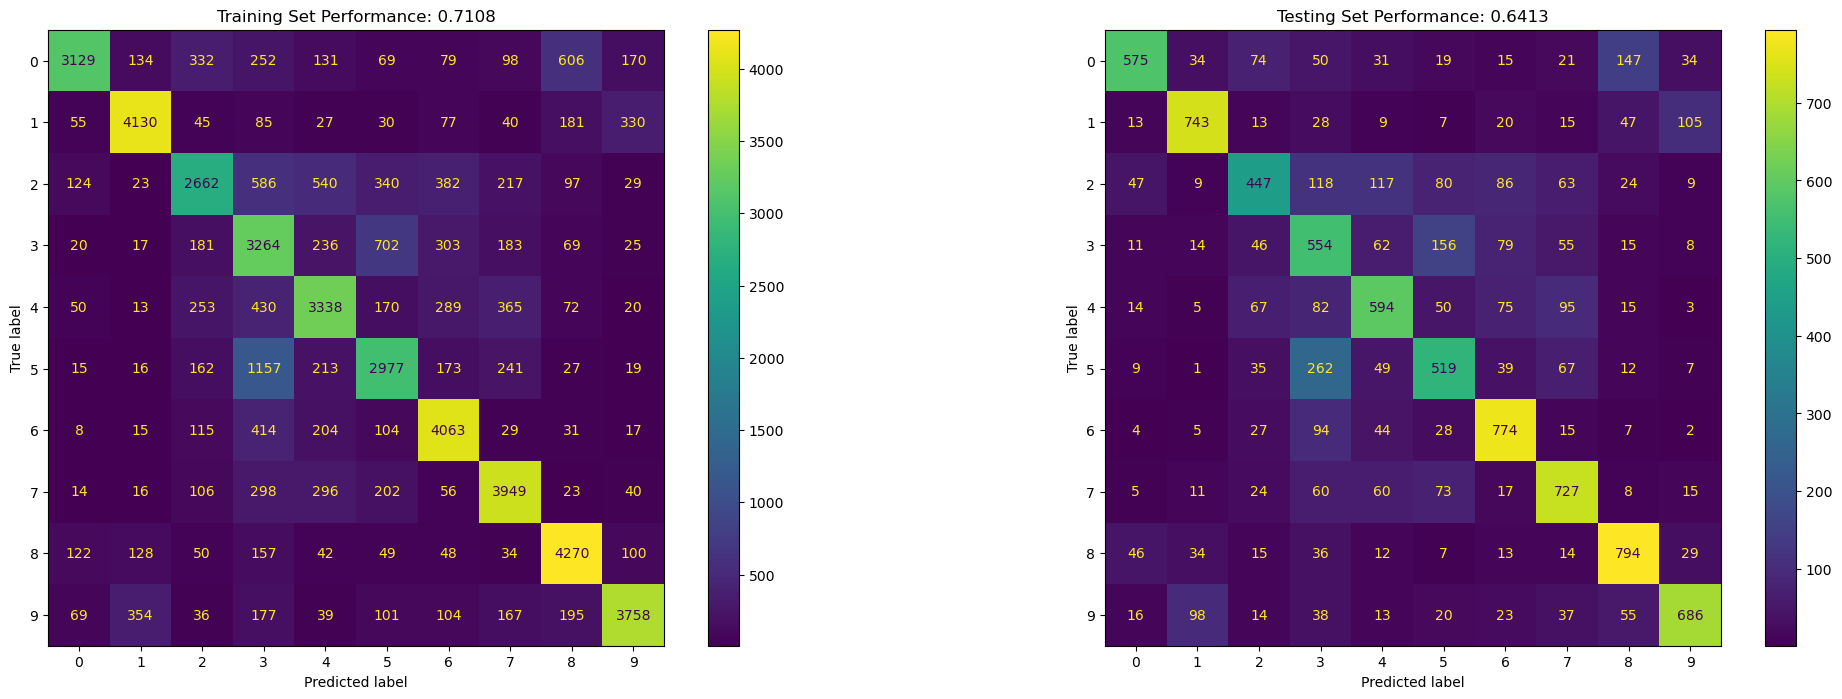

In [17]:
model_cnn, dcnn_train_time, dcnn_metrics = train_and_eval_cnn(x_train, y_train, x_test, y_test, verbose = True)
print('Training Time: %f; Evaluation Time (Test Data): %f' % (dcnn_train_time, dcnn_metrics[1]))

#### Observations

* Our DCNN is way more accurate. This is also a bit unfair though, as it has way more data. 
* Our DCNN is the slowest to train, but the evaluaton time is faster than everything except the random forests and the HOG-CKNN. While we note above that accuracy comparisons are a bit unfair, training time comparisons are also a bit unfair. This model is using way more samples to train.
* Our non-DL methods were all faster when we switched to HOG features (for no loss of accuracy), though when we looked at that we didn't consider the runtime to actually create the HOG features (though we did compute them at time). This is an important consideration. It's not a huge burden here, but this is part of the pipeline. A DCNN does it all in one pass, which perhaps makes the training time a little more acceptable in comparison to the other models, and actually makes our DCNN the fastest of all models on the test set (by a clear margin).
* Someone out there is yelling at the screen, *But you used a GPU for the DCNN!?!? That's not fair!!*. To this, I say:
  * Yes, I did use a GPU for this, but SVMs and CKNNs don't have the same extreme paralellisation benefits that a DCNN does (you can process each tree in a random forest in parallel if you want to). 
  * Nice CUDA implementations of SVMs, CKNNs and Random Forests that allow the use of GPUs don't exist. If you'd like to write some, go for it (it won't be fun).
  * Even if I didn't use a GPU, my evaluation times the DCNN would still be ahead of the CKNN and SVM as I increase the training set size on these models. These methods don't scale well to increases in dataset size.